# Мультипольное разложение в теории электромагнитного поля

В процессе выполнения данной задачи мы рассмотрим электростатический потенциал системы электрических зарядов, введя так называемое _мультипольное разложение_, которое позволит описывать задачу всего лишь небольшим набором чисел и получать при этом решение, хорошо согласующееся с реальными физическими свойствами.
Такой подход подходит не только для потенциала Кулона, но и для гравитационного потенциала Ньютона.

На примере этой задачи рассмотрим сходимость рядов и рекурентных соотношений.
Начнём с визуализации электрического поля системы множества зарядов по аналогии с {ref}`vectorfield_visualization`.
Далее выполним мультипольное разложение, используя _полиномы Лежандра_.
В конце сформируем полноценный модуль Python для решения подобных задач, который будем использовать в последующих задачах.

## Потенциал системы распределённых зарядов

**Общий случай**

Как должно быть известно из курса физики, ротор электрического поля $\mathbf{E}(\mathbf{r})$ в любой точке $\mathbf{r}$ пространства равен нулю.
Следовательно, существует некая _скалярная функция_ $\varphi(\mathbf{r})$, именуемая _электростатическим потенциалом_, градиент которой и есть электрическое поле (ротор градиента всегда равен нулю):

$$
\mathbf{E}(\mathbf{r}) = -\nabla \varphi(\mathbf{r}) =
    -\mathbf{grad}{\varphi(\mathbf{r})},
$$ (E_grad_phi)

где $\nabla$ - векторный дифференциальный оператор, который в случае трёхмерного пространства имеет следующий вид:

$$
\nabla =
    \frac{\partial}{\partial x} \mathbf{i}
    + \frac{\partial}{\partial y} \mathbf{j}
    + \frac{\partial}{\partial z} \mathbf{k},
$$

где $\mathbf{i}$, $\mathbf{j}$, $\mathbf{k}$ - базисные векторы.

```{important}
Знак "минус" в формуле {eq}`E_grad_phi` означает, что в направлении роста потенциала поля (градиент положителен) электрическое поле положительного заряда уменьшается.
Это логично, учитывая физический смысл потенциала: $\varphi$ - это работа электрического поля по перемещению заряда на бесконечное расстояние, где поле отсутствует.
Соответственно, поле, создаваемое положительным зарядом $+q$, совершает положительную работу при перемещении на бесконечность положительного тестового заряда $+Q$, при этом величина поля с расстоянием убывает. 
Вот в чём "природа" минуса в {eq}`E_grad_phi`.
```

```{important}
Знак потенциала $\varphi$ зависит от знака тестового заряда $Q$.
Важно помнить о правиле знаков: $\varphi > 0$ при $Q > 0$ и $\varphi < 0$ при $Q < 0$.
```

Электростатический потенциал точечного (положительного) заряда $q_0$ в некоторой точке пространства с радиус-вектором $\mathbf{r}$ определяется по формуле:

$$
\varphi_0(\mathbf{r}) =
    k \cfrac{q_0}{\| \mathbf{r} - \mathbf{r}_0 \|}.
$$

Несложно убедиться, что для потенциала системы $n$ зарядов так же, как и для поля, справедлив _принцип суперпозиции_:

$$
\varphi(\mathbf{r}) =
    \sum\limits_{i=0}^{n-1}{\varphi_i(\mathbf{r})} =
    \sum\limits_{i=0}^{n-1}{k \cfrac{q_i}{\| \mathbf{r} - \mathbf{r}_i \|}}.
$$

Построим поле 36 зарядов, расположенных равномерно в квадратной сетке $6 \times 6$ при $-0.5 \le x, y \le 0.5$.
Число отрицательных и положительных зарядов одинаково - по 18 штук.

Для начала сформулируем функцию распределения точечных зарядов:

In [21]:
import numpy as np
from src.vectorfield import *


def create_charges(nq):
    vals = [-0.5 + i/(nq - 1) for i in range(nq)]
    qtopos = np.zeros((nq*nq, 3))
    for i, x in enumerate(vals):
        for j, y in enumerate(vals):
            count = j + nq*i + 1
            q = 1.02 * count if (i + j)%2 == 0 else -count
            qtopos[j + nq*i, :] = q, x, y
    return qtopos

...

In [22]:
from src.kahansum import *


def vecmag(rs):
    return np.sqrt(
        kahansum([r**2 for r in rs])
    )


def calc_potential(qtopos, rs):
    potvals = []
    for qri in qtopos:
        q, ri = qri[0], qri[1:]
        diffs = [r - ri for r in rs]
        dr = vecmag(diffs)
        potvals.append(q / dr)
    return kahansum(potvals)

...

In [23]:
qtopos = create_charges(6)
for y in 1., -1.:
    rs = [0., y]
    potval = calc_potential(qtopos, rs)
    print(rs, potval)

[0.0, 1.0] [ 9.09978832 14.55036178]
[0.0, -1.0] [ 4.48425367 -0.96631979]


Строим итоговую картину поля 36 зарядов:

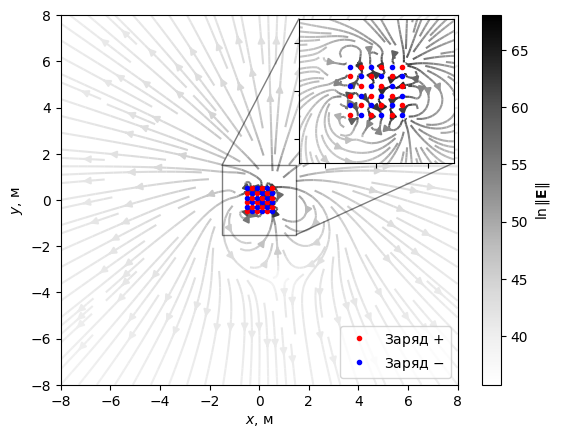

In [24]:
qtopos = create_charges(6)
E = make_vector_field(qtopos)
mesh = create_mesh((-8, 8), (-8, 8), (150, 150))
field = E(mesh)
# График
color = np.log(field[0]**2 + field[1]**2)
fig, ax = plot_vectorfield_2d(
    mesh,
    field,
    color=color,
    cmap="Greys",
    density=1.5,
    cbar_label=r"$\ln{\| \mathbf{E} \|}$"
)
plot_charges(qtopos, (fig, ax))
axins = ax.inset_axes(
    [0.6, 0.6, 0.39, 0.39],
    xlim=(-1.5, 1.5), ylim=(-1.5, 1.5),
    xticklabels=[], yticklabels=[]
)
plot_vectorfield_2d(
    mesh,
    field,
    (fig, axins),
    color=color,
    cmap="Greys",
    density=5
)
plot_charges(qtopos, (fig, axins))
ax.indicate_inset_zoom(axins, edgecolor="k")
ax.set(xlabel="$x$, м", ylabel="$y$, м")
ax.legend();

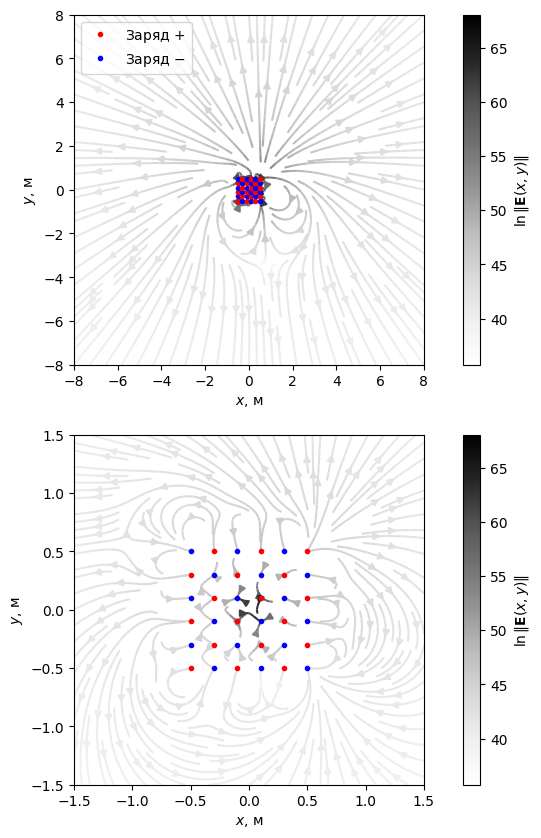

In [25]:
mesh1 = create_mesh((-8, 8), (-8, 8), (150, 150))
mesh2 = create_mesh((-1.5, 1.5), (-1.5, 1.5), (150, 150))
field1 = E(mesh1)
field2 = E(mesh2)
# График
color = np.log(field1[0]**2 + field1[1]**2)
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 10))
plot_vectorfield_2d(
    mesh1,
    field1,
    (fig, ax1),
    color=color,
    cmap="Greys",
    cbar_label=r"$\ln{\| \mathbf{E}(x, y) \|}$",
    density=1.5
)
plot_charges(qtopos, (fig, ax1))
plot_vectorfield_2d(
    mesh2,
    field2,
    (fig, ax2),
    color=color,
    cmap="Greys",
    cbar_label=r"$\ln{\| \mathbf{E}(x, y) \|}$",
    density=1.5
)
plot_charges(qtopos, (fig, ax2))
ax1.set(xlabel="$x$, м", ylabel="$y$, м", aspect="equal")
ax2.set(xlabel="$x$, м", ylabel="$y$, м", aspect="equal")
ax1.legend();